In [1]:
import json
import os
import random
import shutil
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

# Загрузка

In [2]:
from google.colab import files, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!unzip "/content/drive/My Drive/Detection" -d "/content/"

In [4]:
base_dir = "content/DetectionMerged"
img_dir = os.path.join(base_dir, "images/default")
ann_path = os.path.join(base_dir, "annotations", "instances_default.json")

In [5]:
with open(ann_path, 'r') as f:
    coco_data = json.load(f)

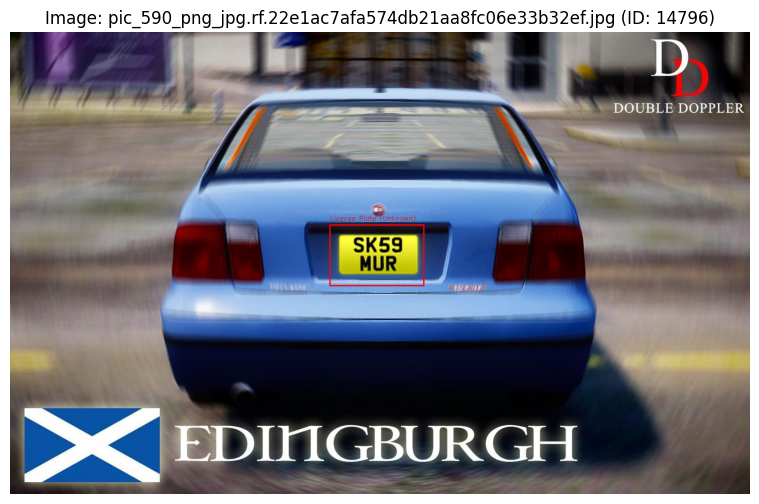

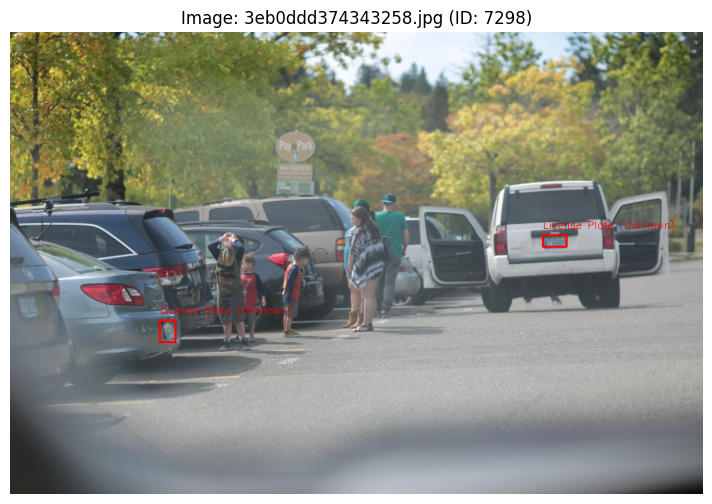

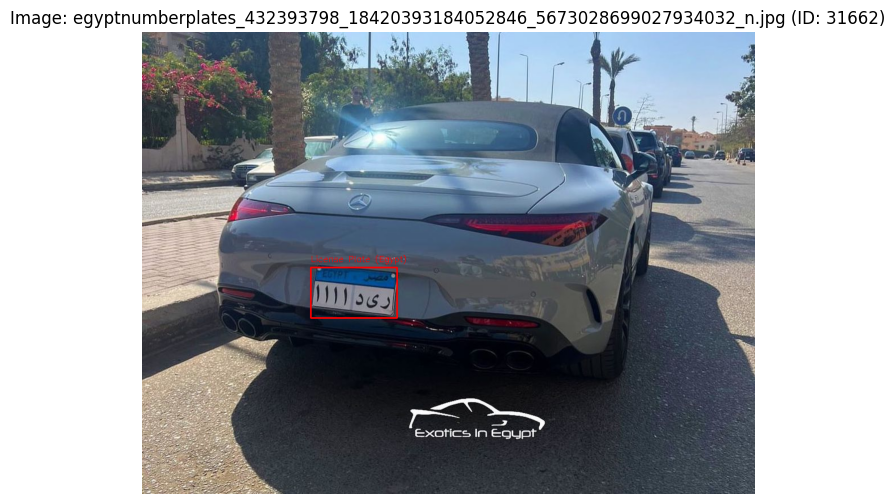

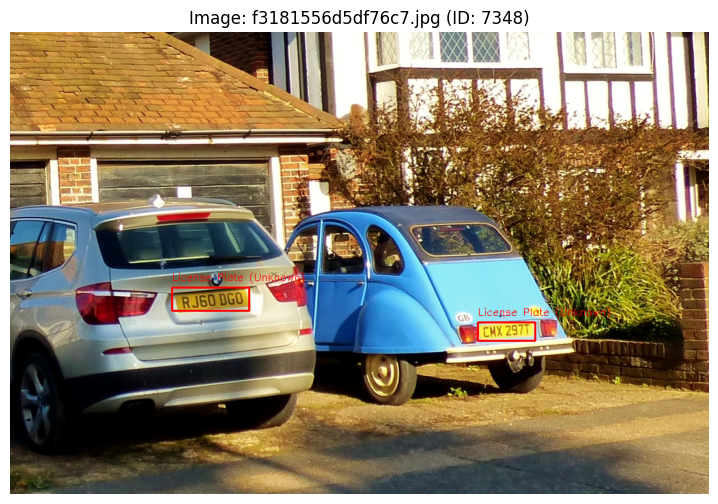

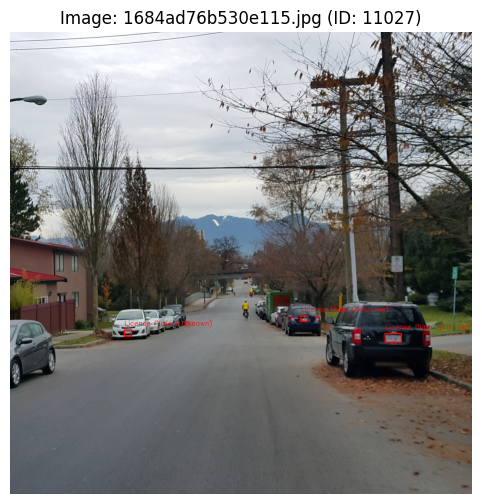

In [6]:
image_id_to_annotations = {}
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    if image_id not in image_id_to_annotations:
        image_id_to_annotations[image_id] = []
    image_id_to_annotations[image_id].append(annotation)

image_id_to_info = {img['id']: img for img in coco_data['images']}

def draw_bboxes(image_path, annotations):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for ann in annotations:
        bbox = ann['bbox']  # [x, y, width, height]
        x, y, w, h = [int(coord) for coord in bbox]

        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

        label = f"License Plate ({ann['attributes']['country']})"
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image

num_images_to_visualize = 5
random_image_ids = random.sample(list(image_id_to_info.keys()), min(num_images_to_visualize, len(image_id_to_info)))

for img_id in random_image_ids:
    img_info = image_id_to_info[img_id]
    img_path = os.path.join(img_dir, img_info['file_name'])
    annotations = image_id_to_annotations.get(img_id, [])

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    image_with_boxes = draw_bboxes(img_path, annotations)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_with_boxes)
    plt.title(f"Image: {img_info['file_name']} (ID: {img_id})")
    plt.axis('off')
    plt.show()

In [7]:
print("Images:", len(coco_data["images"]))
print("Annotations:", len(coco_data["annotations"]))
print("Categories:", coco_data["categories"])

Images: 14721
Annotations: 17552
Categories: [{'id': 1, 'name': 'license_plate', 'supercategory': 'none'}]


## Разбинение на train/test/val

In [8]:
random.seed(42)

images = coco_data["images"]
random.shuffle(images)

n = len(images)
train_split = int(0.7 * n)
val_split   = int(0.9 * n)

splits = {
    "train": images[:train_split],
    "val": images[train_split:val_split],
    "test": images[val_split:],
}

def filter_annotations(images_split, coco_data):
    img_ids = {img["id"] for img in images_split}
    anns = [ann for ann in coco_data["annotations"] if ann["image_id"] in img_ids]
    return {
        "images": images_split,
        "annotations": anns,
        "categories": coco_data["categories"],
    }

out_base = "/content/dataset"
for split in splits:
    os.makedirs(os.path.join(out_base, "images", split), exist_ok=True)

for split, imgs in splits.items():
    split_json = filter_annotations(imgs, coco_data)
    out_json_path = os.path.join(out_base, f"{split}.json")
    with open(out_json_path, "w") as f:
        json.dump(split_json, f)
    print(f"{split}: {len(imgs)} images, {len(split_json['annotations'])} annotations")

    for img in tqdm(imgs, desc=f"Copying {split}"):
        src = os.path.join(img_dir, img["file_name"])
        dst = os.path.join(out_base, "images", split, img["file_name"])
        if os.path.exists(src):
            shutil.copy(src, dst)

train: 10304 images, 12305 annotations


Copying train: 100%|██████████| 10304/10304 [00:17<00:00, 595.00it/s]


val: 2944 images, 3493 annotations


Copying val: 100%|██████████| 2944/2944 [00:04<00:00, 612.82it/s]


test: 1473 images, 1754 annotations


Copying test: 100%|██████████| 1473/1473 [00:02<00:00, 668.78it/s]


In [9]:
!rm -rf content/DetectionMerged/

# Yolo

In [10]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [11]:
from ultralytics.data.converter import convert_coco

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [39]:
# yolo_base = "/content/yolo_dataset"
# coco_ann_dir = "/content/dataset"

# convert_coco(
#     labels_dir=coco_ann_dir,
#     save_dir=yolo_base,
#     use_segments=False,
#     use_keypoints=False,
#     cls91to80=False
# )

src_img_dir = os.path.join("/content/dataset", "images")
dst_img_dir = os.path.join(yolo_base, "images")

if not os.path.exists(dst_img_dir):
    os.makedirs(dst_img_dir)

for split in ["train", "val", "test"]:
    src_split_dir = os.path.join(src_img_dir, split)
    dst_split_dir = os.path.join(dst_img_dir, split)
    os.makedirs(dst_split_dir, exist_ok=True)

    for fname in os.listdir(src_split_dir):
        shutil.copy(os.path.join(src_split_dir, fname), os.path.join(dst_split_dir, fname))

print("YOLO dataset ready at:", yolo_base)

YOLO dataset ready at: /content/yolo_dataset


In [49]:
%cd yolo_dataset/

/content/yolo_dataset


In [50]:
!yolo task=detect mode=train model=yolo11s.pt data=data.yaml epochs=10 imgsz=640


Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fals